In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
%load_ext autoreload

In [3]:
import os
import argparse
import json
import cv2
from keras.models import load_model
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [4]:
%autoreload 2

In [5]:
from utils.utils import get_yolo_boxes
from utils.bbox import draw_boxes

In [6]:
config_path  = "config.json"
input_path = "C:/Users/shaoa/conda_env_tensorflow/keras-yolo3-master/val_data_yolov3/"
#input_path = "D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task2/img/"
#input_path = "D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task3_and_Task4/img/"
input_path = "D:/RRC2019_ReCTS/ReCTS_test_part2-20190420/ReCTS_test_part2/task3_and_task4/img/"

In [7]:
with open(config_path) as config_buffer:    
    config = json.load(config_buffer)

###############################
#   Set some parameter
###############################       
net_h, net_w = 736, 736 # a multiple of 32, the smaller the faster
obj_thresh, nms_thresh = 0.3, 0.2

In [8]:
clahe = cv2.createCLAHE(
    clipLimit=2.0, 
    tileGridSize=(4,4))

In [9]:
def get_direction(im):
    h, w, _ = im.shape
    if w / h >= 1:
        return 'horizontal'
    else:
        return "vertical"

def pad_image(im, size=736):
    h, w, _ = im.shape
    if (h > size) or (w > size):
        size = np.maximum(h, w)
    pad_h = np.maximum(size-h, 0) // 2
    pad_w = np.maximum(size-w, 0) // 2
    
    return np.pad(im, ((pad_h,pad_h), (pad_w,pad_w), (0,0)), 'constant'), pad_h, pad_w

def get_task2_masked_im(fn, use_perspective_transform=False):
    root_path = "D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task2/coordinates"
    im = cv2.imread(f"D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task2/img/{fn}.jpg")
    with open(f"{root_path}/{fn}.txt") as f:
        lines = f.readlines()
        assert len(lines) == 1, lines
        x0, y0, x1, y1,x2, y2, x3, y3 = lines[0].split(",")
        
        masked_im = np.zeros_like(im)
        masked_im = cv2.fillPoly(
            masked_im, 
            [np.array([[x0,y0],[x1,y1],[x2,y2],[x3,y3]]).astype(np.int32).reshape(4,-1,2)],
            (255,255,255))
        masked_im = masked_im.astype(np.float32) / 255 * im
    masked_im = masked_im.astype(np.uint8)
    
    if use_perspective_transform:
        h, w, _ = im.shape
        src = np.array([[x0,y0], [x1,y1], [x2,y2], [x3,y3]], dtype=np.float32)
        dst = np.array([[0,0], [w-1,0], [w-1,h-1], [0,h-1]], dtype=np.float32)
        M = cv2.getPerspectiveTransform(src, dst)
        masked_im = cv2.warpPerspective(masked_im, M, (w, h))
    
    return masked_im    

def get_thresholded_boxes(boxes, thres=obj_thresh):
    return [box for box in boxes if box.score >= obj_thresh]

def remove_small_boxes(boxes, thres=10*10):
    return [box for box in boxes if (box.xmax-box.xmin)*(box.ymax-box.ymin) >= thres]

def convert_boxes_to_ndarray_coords(boxes):
    new_boxes = [np.array([box.xmin,box.ymin,box.xmax,box.ymax, (box.xmin+box.xmax)/2, (box.ymin+box.ymax)/2]) for box in boxes]
    new_boxes = np.array(new_boxes)
    return new_boxes
    
def get_ordered_boxes(boxes, direction="horizontal"):    
    if direction == "horizontal":
        order_axis = -2
    elif direction == "vertical":
        order_axis = -1
    else:
        raise ValueError(f"Received an unknown direction: {direction}.")
    ordered_boxes = boxes[np.argsort(boxes[:, order_axis]), :-2]
    ordered_boxes = ordered_boxes.astype(np.int32)
    return ordered_boxes

def crop_and_save_characters(boxes, im, pad_h, pad_w, fn, max_h, max_w, root_path):
    """
    boxes are assumed to be ordered so that the saved images is correctly named.
    """
    #root_path = "D:/RRC2019_ReCTS/submissions/Task2/intermediate_data2"
    raw_fn = Path(fn).stem
    Path(f"{root_path}/{raw_fn}/img/").mkdir(parents=True, exist_ok=True)
    Path(f"{root_path}/{raw_fn}/coord/").mkdir(parents=True, exist_ok=True)
    for i, box in enumerate(boxes):
        x0, y0, x1, y1 = box[0]-pad_w, box[1]-pad_h, box[2]-pad_w, box[3]-pad_h
        x0, y0, x1, y1 = np.clip(x0, 0, max_w), np.clip(y0, 0, max_h), np.clip(x1, 0, max_w), np.clip(y1, 0, max_h)
        char = im[y0:y1, x0:x1, :]
        cv2.imwrite(f"{root_path}/{raw_fn}/img/{raw_fn}_char_{str(i)}.jpg", char.copy())
        np.save(f"{root_path}/{raw_fn}/coord/{raw_fn}_char_{str(i)}.npy", np.array([x0, y0, x1, y1]))
        
def clahe_rgb(img, l_component_only=False):
    img_eq = np.concatenate([np.expand_dims(clahe.apply(img[...,i:i+1]), -1) for i in range(3)], axis=-1)
    return img_eq

In [10]:
###############################
#   Load the model
###############################
infer_model = load_model(config['train']['saved_weights_name'])   

C:\Users\shaoa\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [59]:
###############################
#   Predict bounding boxes 
###############################
# do detection on an image or a set of images
image_paths = []

if os.path.isdir(input_path): 
    for inp_file in os.listdir(input_path):
        image_paths += [input_path + inp_file]
else:
    image_paths += [input_path]

image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', 'JPEG'])]

In [60]:
image_paths[:5]

['D:/RRC2019_ReCTS/ReCTS_test_part2-20190420/ReCTS_test_part2/task3_and_task4/img/test_ReCTS_task3_and_task_4_002001.jpg',
 'D:/RRC2019_ReCTS/ReCTS_test_part2-20190420/ReCTS_test_part2/task3_and_task4/img/test_ReCTS_task3_and_task_4_002002.jpg',
 'D:/RRC2019_ReCTS/ReCTS_test_part2-20190420/ReCTS_test_part2/task3_and_task4/img/test_ReCTS_task3_and_task_4_002003.jpg',
 'D:/RRC2019_ReCTS/ReCTS_test_part2-20190420/ReCTS_test_part2/task3_and_task4/img/test_ReCTS_task3_and_task_4_002004.jpg',
 'D:/RRC2019_ReCTS/ReCTS_test_part2-20190420/ReCTS_test_part2/task3_and_task4/img/test_ReCTS_task3_and_task_4_002005.jpg']

In [11]:
import time
from pathlib import Path

rand_idx 1689
(714, 1274, 3)
D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task3_and_Task4/img/test_ReCTS_task3_and_task_4_001690.jpg


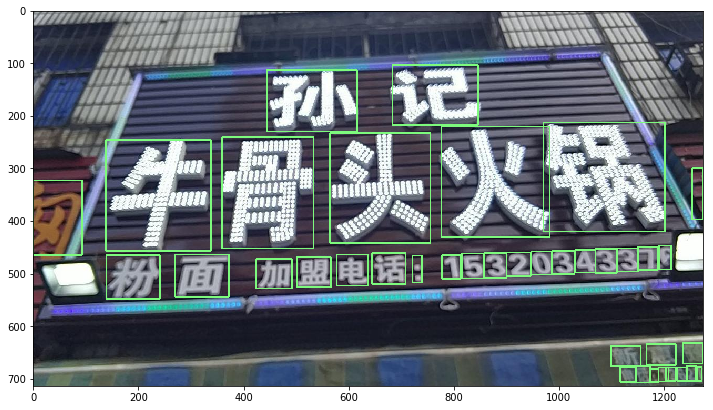

In [47]:
# the main loop
rand_idx = np.random.randint(len(image_paths))
print('rand_idx', rand_idx)

for image_path in image_paths[rand_idx:rand_idx+1]:
    #image_path = "D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task3_and_Task4/img/test_ReCTS_task3_and_task_4_000099.jpg"
    #image_path = "D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task2/img/test_ReCTS_task2_000099.jpg"
    #image_path = "D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task2/img/test_ReCTS_task2_000114.jpg"
    image = cv2.imread(image_path)
    print(image.shape)
    #image = get_task2_masked_im(Path(image_path).stem, False)
    #image = clahe_rgb(image)
    assert not image is None
    direction = get_direction(image)
    #image, ph, pw = pad_image(image) # pad image to (736,736) to prevent outlier zoomed-in text lines
    raw_image = image.copy()
    print(image_path)

    # predict the bounding boxes
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]
    # draw bounding boxes on the image using labels
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 

    # write the image with bounding boxes to file
    #cv2.imwrite(output_path + image_path.split('/')[-1], np.uint8(image))
    plt.figure(figsize=(12,12))
    #plt.subplot(2,1,1)
    #plt.imshow(raw_image[..., ::-1])
    #plt.subplot(2,1,2)
    plt.imshow(np.uint8(image)[..., ::-1])

In [52]:
idx = 3
boxes[idx].xmin, boxes[idx].ymin, boxes[idx].xmax, boxes[idx].ymax, boxes[idx].score

(776, 221, 982, 431, 0.9990834)

In [37]:
%debug

> <ipython-input-35-2ea3e9b84600>(37)get_task2_masked_im()
     35         src = np.array([[x0,y0], [x1,y1], [x2,y2], [x3,y3]])
     36         dst = np.array([[0,0], [w-1,0], [w-1,h-1], [0,h-1]])
---> 37         M = cv2.getPerspectiveTransform(src, dst)
     38         masked_im = cv2.warpPerspective(masked_im, M, (w, h))
     39 

ipdb> src
array([['3', '175'],
       ['671', '1'],
       ['681', '252'],
       ['1', '331']], dtype='<U3')
ipdb> src.shape
(4, 2)
ipdb> q


# Predict on task 2 test data

In [15]:
for image_path in tqdm(image_paths):
    raw_fn = Path(image_path).stem
    image = get_task2_masked_im(raw_fn)
    orig_image = image.copy()
    orig_h, orig_w, _ = orig_image.shape
    assert not image is None
    direction = get_direction(image)
    image, ph, pw = pad_image(image) # pad image to (736,736) to prevent outlier zoomed-in text lines
    #print(image_path)
    root_path = "D:/RRC2019_ReCTS/submissions/Task2/intermediate_data2"

    # predict the bounding boxes
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]
    # draw bounding boxes on the image using labels
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
    
    boxes = get_thresholded_boxes(boxes, obj_thresh)
    boxes = remove_small_boxes(boxes, orig_h/8*orig_w/8)
    if len(boxes) == 0:
        print(f"No character is detected in {raw_fn}.")
        Path(f"{root_path}/{raw_fn}/img/").mkdir(parents=True, exist_ok=True)
        Path(f"{root_path}/{raw_fn}/coord/").mkdir(parents=True, exist_ok=True)
        cv2.imwrite(f"{root_path}/{raw_fn}/img/{raw_fn}_char_0.jpg", orig_image)
        np.save(f"{root_path}/{raw_fn}/coord/{raw_fn}_char_0.npy", np.array([0, 0, orig_w, orig_h]))
        continue
    boxes = convert_boxes_to_ndarray_coords(boxes)
    boxes = get_ordered_boxes(boxes, direction)
    crop_and_save_characters(boxes, orig_image, ph, pw, raw_fn, orig_h, orig_w, root_path)

  1%|▋                                                                              | 96/10789 [00:14<28:23,  6.28it/s]

No character is found in test_ReCTS_task2_000097.


  2%|█▍                                                                            | 202/10789 [00:32<28:17,  6.24it/s]

No character is found in test_ReCTS_task2_000203.


  5%|███▋                                                                          | 503/10789 [01:28<32:13,  5.32it/s]

No character is found in test_ReCTS_task2_000504.


 11%|████████▊                                                                    | 1228/10789 [03:59<32:52,  4.85it/s]

No character is found in test_ReCTS_task2_001229.


 13%|█████████▋                                                                   | 1362/10789 [04:28<31:41,  4.96it/s]

No character is found in test_ReCTS_task2_001363.


 15%|███████████▏                                                                 | 1573/10789 [05:12<26:21,  5.83it/s]

No character is found in test_ReCTS_task2_001574.


 15%|███████████▊                                                                 | 1653/10789 [05:28<28:41,  5.31it/s]

No character is found in test_ReCTS_task2_001654.


 16%|████████████▍                                                                | 1747/10789 [05:46<31:42,  4.75it/s]

No character is found in test_ReCTS_task2_001748.


 18%|█████████████▋                                                               | 1924/10789 [06:21<50:38,  2.92it/s]

No character is found in test_ReCTS_task2_001925.


 19%|██████████████▌                                                              | 2041/10789 [06:48<32:05,  4.54it/s]

No character is found in test_ReCTS_task2_002042.


 19%|██████████████▋                                                              | 2063/10789 [06:53<31:03,  4.68it/s]

No character is found in test_ReCTS_task2_002064.


 19%|██████████████▉                                                              | 2091/10789 [06:59<39:37,  3.66it/s]

No character is found in test_ReCTS_task2_002092.


 20%|███████████████▋                                                             | 2206/10789 [07:20<27:54,  5.13it/s]

No character is found in test_ReCTS_task2_002207.


 28%|█████████████████████▏                                                       | 2976/10789 [10:08<26:32,  4.91it/s]

No character is found in test_ReCTS_task2_002977.


 28%|█████████████████████▋                                                       | 3038/10789 [10:21<23:45,  5.44it/s]

No character is found in test_ReCTS_task2_003039.


 29%|██████████████████████▌                                                      | 3165/10789 [10:47<45:50,  2.77it/s]

No character is found in test_ReCTS_task2_003166.


 31%|███████████████████████▊                                                     | 3334/10789 [11:21<23:39,  5.25it/s]

No character is found in test_ReCTS_task2_003335.


 33%|█████████████████████████▎                                                   | 3554/10789 [12:10<23:50,  5.06it/s]

No character is found in test_ReCTS_task2_003555.


 39%|█████████████████████████████▊                                               | 4178/10789 [14:13<20:21,  5.41it/s]

No character is found in test_ReCTS_task2_004179.


 40%|██████████████████████████████▍                                              | 4267/10789 [14:30<20:06,  5.41it/s]

No character is found in test_ReCTS_task2_004268.


 44%|██████████████████████████████████▏                                          | 4796/10789 [16:13<33:56,  2.94it/s]

No character is found in test_ReCTS_task2_004797.


 46%|███████████████████████████████████▏                                         | 4933/10789 [16:41<20:13,  4.82it/s]

No character is found in test_ReCTS_task2_004934.


 53%|█████████████████████████████████████████▏                                   | 5768/10789 [19:21<15:07,  5.53it/s]

No character is found in test_ReCTS_task2_005769.


 60%|██████████████████████████████████████████████▎                              | 6495/10789 [21:45<12:28,  5.74it/s]

No character is found in test_ReCTS_task2_006496.


 61%|██████████████████████████████████████████████▋                              | 6538/10789 [21:54<13:30,  5.25it/s]

No character is found in test_ReCTS_task2_006539.


 62%|███████████████████████████████████████████████▋                             | 6682/10789 [22:22<12:28,  5.49it/s]

No character is found in test_ReCTS_task2_006683.


 65%|█████████████████████████████████████████████████▉                           | 6998/10789 [23:20<12:10,  5.19it/s]

No character is found in test_ReCTS_task2_006999.


 66%|██████████████████████████████████████████████████▌                          | 7076/10789 [23:36<10:31,  5.88it/s]

No character is found in test_ReCTS_task2_007077.


 67%|███████████████████████████████████████████████████▊                         | 7252/10789 [24:09<10:51,  5.43it/s]

No character is found in test_ReCTS_task2_007253.


 67%|███████████████████████████████████████████████████▉                         | 7269/10789 [24:12<11:09,  5.26it/s]

No character is found in test_ReCTS_task2_007270.


 67%|███████████████████████████████████████████████████▉                         | 7276/10789 [24:14<11:17,  5.19it/s]

No character is found in test_ReCTS_task2_007277.


 68%|████████████████████████████████████████████████████▍                        | 7352/10789 [24:28<10:03,  5.69it/s]

No character is found in test_ReCTS_task2_007353.


 70%|█████████████████████████████████████████████████████▊                       | 7543/10789 [25:05<16:05,  3.36it/s]

No character is found in test_ReCTS_task2_007544.


 70%|█████████████████████████████████████████████████████▉                       | 7554/10789 [25:07<09:49,  5.48it/s]

No character is found in test_ReCTS_task2_007555.


 75%|█████████████████████████████████████████████████████████▋                   | 8086/10789 [26:47<08:28,  5.31it/s]

No character is found in test_ReCTS_task2_008087.


 77%|███████████████████████████████████████████████████████████▌                 | 8337/10789 [27:34<07:18,  5.59it/s]

No character is found in test_ReCTS_task2_008338.


 78%|███████████████████████████████████████████████████████████▉                 | 8402/10789 [27:45<06:55,  5.75it/s]

No character is found in test_ReCTS_task2_008403.


 82%|███████████████████████████████████████████████████████████████▍             | 8897/10789 [29:18<05:18,  5.93it/s]

No character is found in test_ReCTS_task2_008898.


 86%|█████████████████████████████████████████████████████████████████▉           | 9234/10789 [30:20<04:50,  5.36it/s]

No character is found in test_ReCTS_task2_009235.


 89%|████████████████████████████████████████████████████████████████████▎        | 9567/10789 [31:22<04:18,  4.72it/s]

No character is found in test_ReCTS_task2_009568.


 89%|████████████████████████████████████████████████████████████████████▎        | 9577/10789 [31:24<03:45,  5.37it/s]

No character is found in test_ReCTS_task2_009578.


 90%|████████████████████████████████████████████████████████████████████▉        | 9665/10789 [31:40<03:38,  5.13it/s]

No character is found in test_ReCTS_task2_009666.


 92%|██████████████████████████████████████████████████████████████████████▋      | 9911/10789 [32:26<02:39,  5.50it/s]

No character is found in test_ReCTS_task2_009912.


 94%|███████████████████████████████████████████████████████████████████████▋    | 10172/10789 [33:15<01:53,  5.44it/s]

No character is found in test_ReCTS_task2_010173.


 97%|█████████████████████████████████████████████████████████████████████████▉  | 10501/10789 [34:16<00:54,  5.24it/s]

No character is found in test_ReCTS_task2_010502.


100%|███████████████████████████████████████████████████████████████████████████▋| 10747/10789 [35:01<00:07,  5.40it/s]

No character is found in test_ReCTS_task2_010748.


100%|████████████████████████████████████████████████████████████████████████████| 10789/10789 [35:09<00:00,  5.57it/s]


In [16]:
fns_no_char_detected = ["test_ReCTS_task2_000097", "test_ReCTS_task2_000203", "test_ReCTS_task2_000504", "test_ReCTS_task2_001229", "test_ReCTS_task2_001363", "test_ReCTS_task2_001574", "test_ReCTS_task2_001654", "test_ReCTS_task2_001748", "test_ReCTS_task2_001925", "test_ReCTS_task2_002042", "test_ReCTS_task2_002064", "test_ReCTS_task2_002092", "test_ReCTS_task2_002207", "test_ReCTS_task2_002977", "test_ReCTS_task2_003039", "test_ReCTS_task2_003166", "test_ReCTS_task2_003335", "test_ReCTS_task2_003555", "test_ReCTS_task2_004179", "test_ReCTS_task2_004268", "test_ReCTS_task2_004797", "test_ReCTS_task2_004934", "test_ReCTS_task2_005769", "test_ReCTS_task2_006496", "test_ReCTS_task2_006539", "test_ReCTS_task2_006683", "test_ReCTS_task2_006999", "test_ReCTS_task2_007077", "test_ReCTS_task2_007253", "test_ReCTS_task2_007270", "test_ReCTS_task2_007277", "test_ReCTS_task2_007353", "test_ReCTS_task2_007544", "test_ReCTS_task2_007555", "test_ReCTS_task2_008087", "test_ReCTS_task2_008338", "test_ReCTS_task2_008403", "test_ReCTS_task2_008898", "test_ReCTS_task2_008898", "test_ReCTS_task2_009235", "test_ReCTS_task2_009568", "test_ReCTS_task2_009578", "test_ReCTS_task2_009666", "test_ReCTS_task2_009912", "test_ReCTS_task2_010173", "test_ReCTS_task2_010502", "test_ReCTS_task2_010748",]

In [19]:
for fn in tqdm(fns_no_char_detected):
    raw_fn = Path(fn).stem
    root_path = "D:/RRC2019_ReCTS/submissions/Task2/intermediate_data2_missed_images"
    
    # ====================
    #Step 1: resize (to 352)
    # ====================
    image = get_task2_masked_im(raw_fn)    
    long_side = np.max(image.shape[:2]) # =====
    resize_ratio = 352 / long_side # =====
    image = cv2.resize(image, (0,0), fx=resize_ratio, fy=resize_ratio) # =====  
    orig_image = image.copy()
    orig_h, orig_w, _ = orig_image.shape
    assert not image is None        
    direction = get_direction(image)
    image, ph, pw = pad_image(image)
    
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]    
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
    
    boxes = get_thresholded_boxes(boxes, obj_thresh)
    boxes = remove_small_boxes(boxes, orig_h/8*orig_w/8)
    if len(boxes) != 0:
        boxes = convert_boxes_to_ndarray_coords(boxes)
        boxes = get_ordered_boxes(boxes, direction)
        crop_and_save_characters(boxes, orig_image, ph, pw, raw_fn, orig_h, orig_w, root_path)
        continue
    
    # ====================
    #Step 2: perspective transform
    # ====================
    image = get_task2_masked_im(raw_fn, True) # =====
    orig_image = image.copy()
    orig_h, orig_w, _ = orig_image.shape
    assert not image is None
    direction = get_direction(image)
    image, ph, pw = pad_image(image)
    
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]    
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
    
    boxes = get_thresholded_boxes(boxes, obj_thresh)
    boxes = remove_small_boxes(boxes, orig_h/8*orig_w/8)
    if len(boxes) != 0:
        boxes = convert_boxes_to_ndarray_coords(boxes)
        boxes = get_ordered_boxes(boxes, direction)
        crop_and_save_characters(boxes, orig_image, ph, pw, raw_fn, orig_h, orig_w, root_path)
        continue  
    
    # ====================
    #Step 3: perspective transform + resize (to 352)
    # ====================
    image = get_task2_masked_im(raw_fn, True) # =====
    long_side = np.max(image.shape[:2]) # =====
    resize_ratio = 352 / long_side # =====
    image = cv2.resize(image, (0,0), fx=resize_ratio, fy=resize_ratio) # =====  
    orig_image = image.copy()
    orig_h, orig_w, _ = orig_image.shape
    assert not image is None        
    direction = get_direction(image)
    image, ph, pw = pad_image(image)
    
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]    
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
    
    boxes = get_thresholded_boxes(boxes, obj_thresh)
    boxes = remove_small_boxes(boxes, orig_h/8*orig_w/8)
    if len(boxes) != 0:
        boxes = convert_boxes_to_ndarray_coords(boxes)
        boxes = get_ordered_boxes(boxes, direction)
        crop_and_save_characters(boxes, orig_image, ph, pw, raw_fn, orig_h, orig_w, root_path)
        continue  
        
    print(f"No character is detected in {raw_fn}")

  0%|                                                                                           | 0/47 [00:00<?, ?it/s]

No character is detected in test_ReCTS_task2_000097


 13%|██████████▌                                                                        | 6/47 [00:01<00:14,  2.92it/s]

No character is detected in test_ReCTS_task2_001654


 17%|██████████████▏                                                                    | 8/47 [00:02<00:11,  3.32it/s]

No character is detected in test_ReCTS_task2_001925


 19%|███████████████▉                                                                   | 9/47 [00:02<00:12,  2.97it/s]

No character is detected in test_ReCTS_task2_002042


 26%|████████████████████▉                                                             | 12/47 [00:03<00:09,  3.57it/s]

No character is detected in test_ReCTS_task2_002207


 36%|█████████████████████████████▋                                                    | 17/47 [00:05<00:07,  4.12it/s]

No character is detected in test_ReCTS_task2_003555


 38%|███████████████████████████████▍                                                  | 18/47 [00:05<00:08,  3.39it/s]

No character is detected in test_ReCTS_task2_004179


 49%|████████████████████████████████████████▏                                         | 23/47 [00:07<00:07,  3.42it/s]

No character is detected in test_ReCTS_task2_006496


 55%|█████████████████████████████████████████████▎                                    | 26/47 [00:07<00:06,  3.29it/s]

No character is detected in test_ReCTS_task2_006999


 66%|██████████████████████████████████████████████████████                            | 31/47 [00:09<00:04,  3.40it/s]

No character is detected in test_ReCTS_task2_007353


 68%|███████████████████████████████████████████████████████▊                          | 32/47 [00:09<00:04,  3.03it/s]

No character is detected in test_ReCTS_task2_007544


 70%|█████████████████████████████████████████████████████████▌                        | 33/47 [00:10<00:04,  2.81it/s]

No character is detected in test_ReCTS_task2_007555


 72%|███████████████████████████████████████████████████████████▎                      | 34/47 [00:10<00:04,  2.65it/s]

No character is detected in test_ReCTS_task2_008087


 74%|█████████████████████████████████████████████████████████████                     | 35/47 [00:11<00:04,  2.58it/s]

No character is detected in test_ReCTS_task2_008338


 77%|██████████████████████████████████████████████████████████████▊                   | 36/47 [00:11<00:04,  2.54it/s]

No character is detected in test_ReCTS_task2_008403


 85%|█████████████████████████████████████████████████████████████████████▊            | 40/47 [00:12<00:01,  3.70it/s]

No character is detected in test_ReCTS_task2_009568


 91%|███████████████████████████████████████████████████████████████████████████       | 43/47 [00:13<00:01,  3.76it/s]

No character is detected in test_ReCTS_task2_009912


 94%|████████████████████████████████████████████████████████████████████████████▊     | 44/47 [00:13<00:00,  3.24it/s]

No character is detected in test_ReCTS_task2_010173


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:14<00:00,  3.77it/s]


# Generate prediciton on Task 3 images

In [56]:
root_path = "D:/RRC2019_ReCTS/submissions/Task3/YOLOv3_bboxes"

for image_path in tqdm(image_paths):
    raw_fn = Path(image_path).stem
    image = cv2.imread(image_path)
    assert not image is None
    
    # predict the bounding boxes
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]
    # draw bounding boxes on the image using labels
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
    
    Path(f"{root_path}/{raw_fn}").mkdir(parents=True, exist_ok=True)
    with open(f"{root_path}/{raw_fn}/{raw_fn}.txt", 'w', encoding="utf-8_sig") as f:
        for box in boxes:
            if box.score >= obj_thresh:
                x0, y0, x1, y1 = box.xmin, box.ymin, box.xmax, box.ymax
                score = box.score
                f.write(str(x0) + "," + str(y0) + "," + str(x1) + "," + str(y1) + "," + str(score) + "\n")
    plt.imsave(fname=f"{root_path}/{raw_fn}/{raw_fn}.jpg", arr=np.uint8(image)[..., ::-1], format="jpg")

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:36<00:00,  4.45it/s]


In [61]:
root_path = "D:/RRC2019_ReCTS/submissions/Task3/YOLOv3_bboxes"

for image_path in tqdm(image_paths):
    raw_fn = Path(image_path).stem
    image = cv2.imread(image_path)
    assert not image is None
    
    # predict the bounding boxes
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]
    # draw bounding boxes on the image using labels
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
    
    Path(f"{root_path}/{raw_fn}").mkdir(parents=True, exist_ok=True)
    with open(f"{root_path}/{raw_fn}/{raw_fn}.txt", 'w', encoding="utf-8_sig") as f:
        for box in boxes:
            if box.score >= obj_thresh:
                x0, y0, x1, y1 = box.xmin, box.ymin, box.xmax, box.ymax
                score = box.score
                f.write(str(x0) + "," + str(y0) + "," + str(x1) + "," + str(y1) + "," + str(score) + "\n")
    plt.imsave(fname=f"{root_path}/{raw_fn}/{raw_fn}.jpg", arr=np.uint8(image)[..., ::-1], format="jpg")

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [13:08<00:00,  3.62it/s]


# Evaluation on valid. data

In [12]:
!python train.py -c config.json

Seen labels: 	{'char': 259295}

Given labels: 	['char']

Training on: 	['char']


Loading pretrained weights.

char: 0.7081
mAP: 0.7081


2019-05-01 14:45:32.233915: I T:\src\github\tensorflow\tensorflow\core\platform\cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
2019-05-01 14:45:32.453592: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:1392] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.6575
pciBusID: 0000:05:00.0
totalMemory: 11.00GiB freeMemory: 9.10GiB
2019-05-01 14:45:32.454047: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:1471] Adding visible gpu devices: 0
2019-05-01 14:45:33.076442: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:952] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-05-01 14:45:33.089474: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:958]      0 
2019-05-01 14:45:33.104372: I T:\src\github\tensorflow\tensorflow\core\common_runtime\gpu\gpu_

In [16]:
get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0][2].score

-1

In [17]:
get_ordered_boxes(convert_boxes_to_ndarray_coords(get_thresholded_boxes(boxes, obj_thresh)))

AttributeError: 'numpy.ndarray' object has no attribute 'score'

In [165]:
%debug

> <ipython-input-158-af98b53e1858>(48)get_ordered_boxes()
     46     else:
     47         raise ValueError(f"Received an unknown direction: {direction}.")
---> 48     ordered_boxes = boxes[np.argsort(boxes[:, order_axis]), :-2]
     49     ordered_boxes = ordered_boxes.astype(np.int32)
     50     return ordered_boxes

ipdb> boxes
array([], dtype=float64)
ipdb> q


In [122]:
raw_im = cv2.imread("D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task2/img/test_ReCTS_task2_003485.jpg")

713 619 769 663 424 0


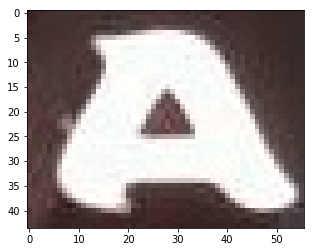

In [141]:
plt.imshow(crop_character(boxes[37], raw_im, ph, pw))

In [23]:
for i, box in enumerate(boxes):
    if box.score >= obj_thresh:
        print(box.xmin, box.ymin, box.xmax, box.ymax, (box.xmax-box.xmin)*(box.ymax-box.ymin), i)

329 360 336 368 56 0
334 360 342 368 64 1
343 360 350 368 56 2
351 360 357 368 48 3
360 360 366 368 48 4
368 361 375 368 49 5
376 361 383 368 49 6
384 361 390 368 42 7
391 360 399 369 72 8
330 368 335 374 30 10
335 368 342 374 42 11
343 367 350 374 49 12
352 367 359 374 49 13
360 366 367 374 56 14
368 366 376 374 64 15
377 367 384 374 49 16
384 367 391 374 49 17
391 367 399 374 56 18
398 365 405 374 63 19


In [149]:
thres_boxes = np.array([np.array([box.xmin,box.ymin,box.xmax,box.ymax, (box.xmin+box.xmax)/2, (box.ymin+box.ymax)/2]) for box in boxes if box.score >= obj_thresh])
thres_boxes

array([[ 251. ,  430. ,  633. ,  667. ,  442. ,  548.5],
       [  34. ,  464. ,  287. ,  619. ,  160.5,  541.5],
       [ 602. ,  490. ,  814. ,  642. ,  708. ,  566. ],
       [ 819. ,  445. , 1091. ,  687. ,  955. ,  566. ],
       [ 617. ,  568. ,  671. ,  607. ,  644. ,  587.5],
       [ 668. ,  570. ,  692. ,  606. ,  680. ,  588. ],
       [ 701. ,  581. ,  733. ,  609. ,  717. ,  595. ],
       [ 617. ,  616. ,  665. ,  659. ,  641. ,  637.5],
       [ 668. ,  619. ,  713. ,  661. ,  690.5,  640. ],
       [ 713. ,  619. ,  769. ,  663. ,  741. ,  641. ]])

In [152]:
thres_boxes[np.argsort(thres_boxes[:, -2]), :-2]

array([[  34.,  464.,  287.,  619.],
       [ 251.,  430.,  633.,  667.],
       [ 617.,  616.,  665.,  659.],
       [ 617.,  568.,  671.,  607.],
       [ 668.,  570.,  692.,  606.],
       [ 668.,  619.,  713.,  661.],
       [ 602.,  490.,  814.,  642.],
       [ 701.,  581.,  733.,  609.],
       [ 713.,  619.,  769.,  663.],
       [ 819.,  445., 1091.,  687.]])

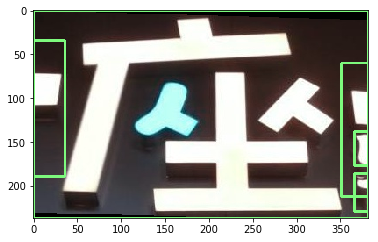

In [137]:
plt.imshow(image[430:667,251:633,:])

In [37]:
xx = open("D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task2/coordinates/test_ReCTS_task2_003485.txt")

In [38]:
lines = xx.readlines()

In [39]:
assert len(lines) == 1, lines

In [40]:
x0,y0,x1,y1,x2,y2,x3,y3 = lines[0].split(",")

In [119]:
im_ = cv2.imread("D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task2/img/test_ReCTS_task2_003485.jpg")

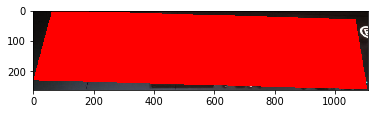

In [47]:
masked_im = np.zeros_like(im_)

plt.imshow(cv2.fillPoly(im_, [np.array([[x0,y0],[x1,y1],[x2,y2],[x3,y3]]).astype(np.int32).reshape(4,-1,2)], (255,0,0)))

In [32]:
np.array([[x0,y0],[x1,y1],[x2,y2],[x3,y3]]).astype(np.int32).shape

(4, 2)

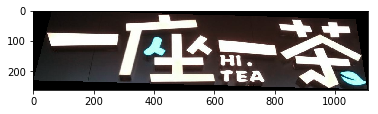

In [64]:
plt.imshow(get_task2_masked_im("test_ReCTS_task2_003485"))

In [7]:
xx = cv2.imread("D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task2/img/test_ReCTS_task2_008273.jpg")[..., ::-1]

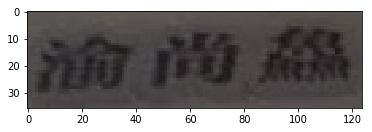

In [8]:
plt.imshow(xx)

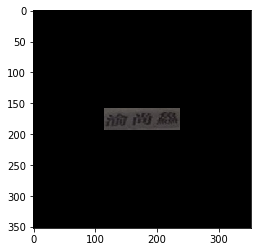

In [36]:
plt.imshow(pad_image(xx))